In [1]:
import tensorflow as tf

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
import glob
import cv2
from random import randrange
from IPython import display
tf.__version__


'1.14.0'

In [2]:
# (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
# train_images[0]
tf.enable_eager_execution()
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
session = tf.InteractiveSession(config=config)

In [3]:
def get_images():
    train_images = []
    test_images = []
    for file in glob.glob("./images/*"):
        try:
            if "test" in file:
                continue
            im = cv2.imread(file)
            im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
#             _,im = cv2.threshold(im,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
            train_images.append(im)
        except:
            print(file)
    for file in glob.glob("./images/test/*"):
        im = cv2.imread(file)
        im = cv2.cvtColor(im,cv2.COLOR_RGB2GRAY)
#         _,im = cv2.threshold(im,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        test_images.append(im)
    return (np.array(train_images), None), (np.array(test_images), None)

./images/loop_gazebo_images.zip
16896 7146


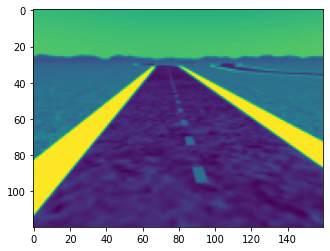

In [4]:
(train_images, _), (test_images, _) = get_images()
plt.imshow(train_images[0])
print(len(train_images), len(test_images))
# print((train_images[0]))

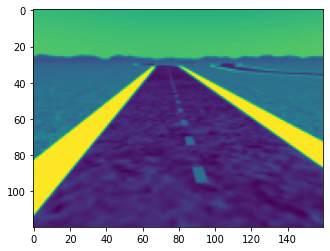

In [5]:
train_images = train_images.reshape(train_images.shape[0], 120, 160, 1).astype('float32')
test_images = test_images.reshape(test_images.shape[0], 120, 160, 1).astype('float32')

# Normalizing the images to the range of [0., 1.]
# done by threshold
train_images /= 255.
test_images /= 255.

# Binarization
# also done by threshold
# train_images[train_images >= .5] = 1.
# train_images[train_images < .5] = 0.
# test_images[test_images >= .5] = 1.
# test_images[test_images < .5] = 0.

plt.imshow(train_images[0].squeeze())

In [6]:
TRAIN_BUF = 500
BATCH_SIZE = 200

TEST_BUF = 100


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(TEST_BUF).batch(BATCH_SIZE)


In [24]:
class CVAE(tf.keras.Model):
  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.inference_net = tf.keras.Sequential(
      [
          tf.keras.layers.InputLayer(input_shape=(120, 160, 1)),
          tf.keras.layers.Conv2D(
              filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Conv2D(
              filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
          tf.keras.layers.Flatten(),
          # No activation
          tf.keras.layers.Dense(latent_dim + latent_dim),
      ]
    )

    self.generative_net = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=30*40*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(30, 40, 32)),
          tf.keras.layers.Conv2DTranspose(
              filters=64,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          tf.keras.layers.Conv2DTranspose(
              filters=32,
              kernel_size=3,
              strides=(2, 2),
              padding="SAME",
              activation='relu'),
          # No activation
          tf.keras.layers.Conv2DTranspose(
              filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.generative_net(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs

    return logits

In [25]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

@tf.function
def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))


In [26]:
epochs = 100
latent_dim = 5
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)


In [27]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model.sample(test_input)
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # tight_layout minimizes the overlap between 2 sub-plots
  plt.savefig('images_out/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


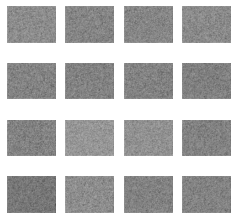

In [28]:
generate_and_save_images(model, 0, random_vector_for_generation)


Epoch: 36, Test set ELBO: -11200.06640625, time elapse for current epoch 61.628652572631836


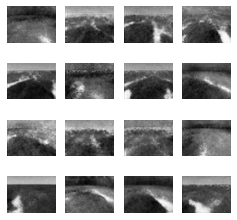

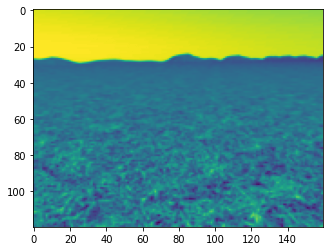

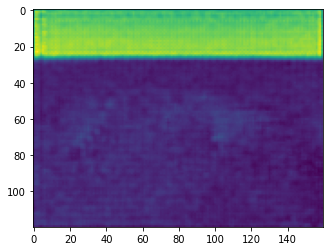

KeyboardInterrupt: 

In [29]:
start_epoch = 1
for epoch in range(start_epoch, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    compute_apply_gradients(model, train_x, optimizer)
  end_time = time.time()

  if epoch % 1 == 0:
    loss = tf.keras.metrics.Mean()
    for test_x in test_dataset:
      loss(compute_loss(model, test_x))
    elbo = -loss.result()
    display.clear_output(wait=False)
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
    generate_and_save_images(
        model, epoch, random_vector_for_generation)
    i=randrange(len(test_images))
    plt.imshow(test_images[i].squeeze())
    plt.show()
    space = model.encode(test_images[i].squeeze().reshape(1,120,160,1))
#     space
    out = model.decode(space)
    plt.imshow(np.squeeze(out))
    plt.show()
  if epoch % 5 == 0:
    model.save_weights("./checkpoints/model_" + str(epoch))


In [ ]:
# model.compile(optimizer, loss)
model.load_weights("./checkpoints/model_35")

In [ ]:
i=1
plt.imshow(test_images[i].squeeze())
plt.show()
space = model.encode(test_images[i].squeeze().reshape(1,120,160,1))
print(np.array(space))
out = model.decode(space[0])
plt.imshow(np.squeeze(out))

In [ ]:
space_out = np.array(space[0])
print(space_out)
print(space_out.shape)
empty_space = np.zeros(space_out.shape)
print(empty_space[0])
out = model.decode(empty_space)
plt.imshow(np.squeeze(out))